<a href="https://www.kaggle.com/code/arwaabouattia/human-activity-recognition-using-lstm-cnn?scriptVersionId=229337313" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Human Activity Recognition Using CNN-LSTM🤹🏻‍♀️🤠

This notebook demonstrates a complete workflow for building, training, and evaluating a memory-efficient CNN-LSTM model using the **UCF101 dataset**. 

# 1- Import required libraries and modules 📚

In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.layers import LSTM, TimeDistributed, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from glob import glob
import cv2
from tqdm import tqdm

# 2- Configuration Parameters ✍🏽

Define configuration parameters for paths, image processing, and model training.

In [2]:
class Config:
    # Paths
    BASE_PATH = '/kaggle/input/ucf101-frames'
    TRAIN_PATH = os.path.join(BASE_PATH, 'train')
    TEST_PATH = os.path.join(BASE_PATH, 'test')
    MODEL_SAVE_PATH = '/kaggle/working/activity_recognition_model.keras'
    CLASS_NAMES_PATH = '/kaggle/working/class_names.npy'
    
    # Data parameters
    IMG_SIZE = (160, 160)  # Input image size (160, 160)
    NUM_FRAMES = 16  # Increased from 8 to capture more temporal information
    NUM_CLASSES = 101  # UCF101 has 101 classes
    
    # Model parameters
    BATCH_SIZE = 4
    EPOCHS = 50
    LEARNING_RATE = 0.0001
    
    # Data file
    DATA_FILE = '/kaggle/input/ucf101-frames/data_file.csv'

### display sample frames

In [3]:
DATA_FILE = '/kaggle/input/ucf101-frames/data_file.csv'
TRAIN_PATH = '/kaggle/input/ucf101-frames/train'
df = pd.read_csv(DATA_FILE)

class_info = df.iloc[:, 1].values 
class_names = np.unique(class_info)
np.save('class_names.npy', class_names)

class_names = np.unique(class_info)

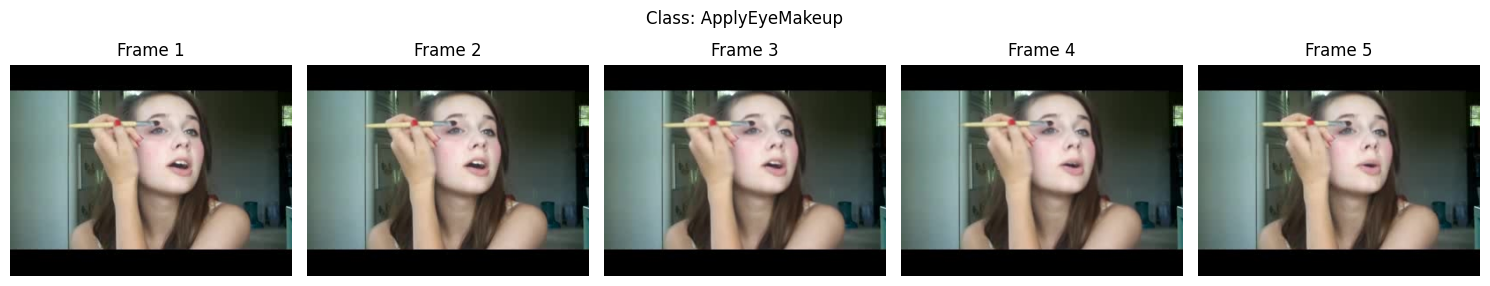

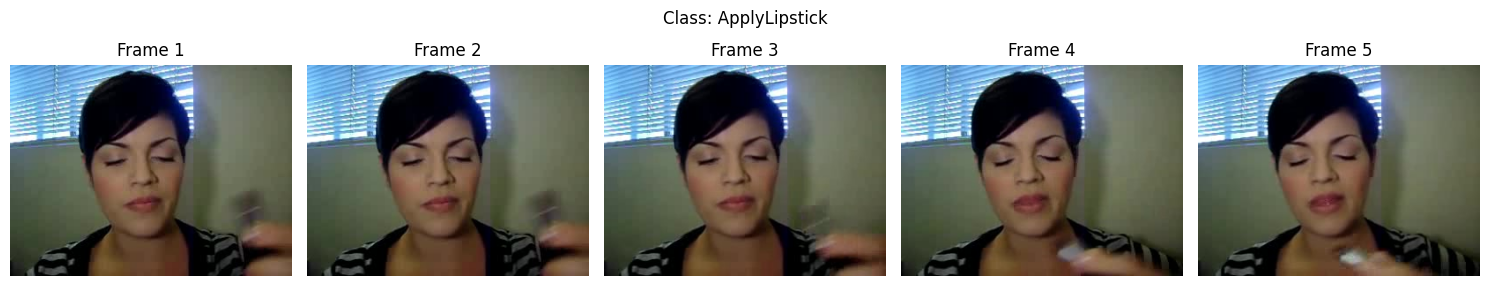

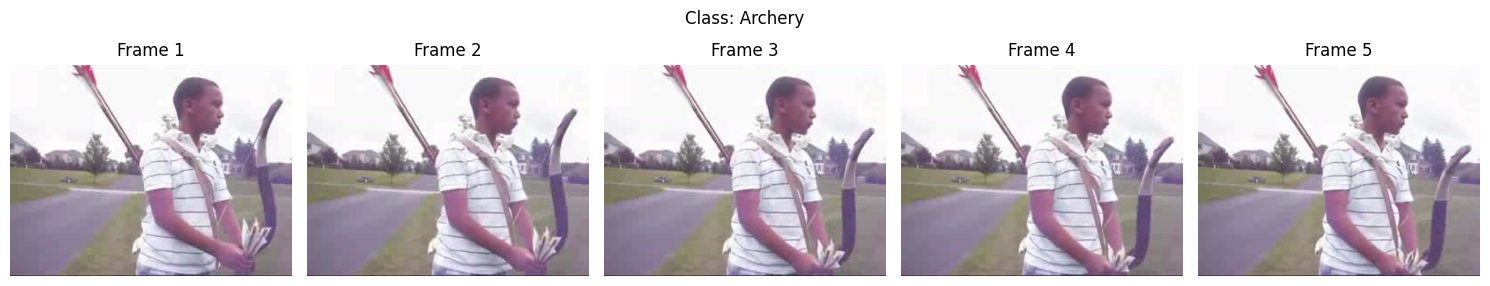

In [4]:
def display_sample_frames(class_name, num_frames=5):
    """Display sample frames from a specific class"""
    # Try train path first
    video_path = os.path.join(TRAIN_PATH, class_name)
    
    if not os.path.exists(video_path):
        # Try test path if not found in train
        video_path = os.path.join(TEST_PATH, class_name)
        
    if not os.path.exists(video_path):
        print(f"Class {class_name} not found in dataset!")
        return
    
    frame_files = sorted(os.listdir(video_path))
    if len(frame_files) >= num_frames:
        frame_files = frame_files[:num_frames]
    else:
        print(f"Warning: Only {len(frame_files)} frames found for {class_name}")
    
    plt.figure(figsize=(15, 3))
    for i, frame in enumerate(frame_files):
        img = cv2.imread(os.path.join(video_path, frame))
        if img is None:
            print(f"Error loading image: {os.path.join(video_path, frame)}")
            continue
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(1, len(frame_files), i+1)
        plt.imshow(img)
        plt.title(f"Frame {i+1}")
        plt.axis("off")
    plt.suptitle(f"Class: {class_name}")
    plt.tight_layout()
    plt.show()

for cls in class_names[:3]:
    display_sample_frames(cls)

# 3- Functions to organize operations 🧱

In [5]:
# Data preparation functions
def load_and_preprocess_frame(frame_path, img_size=(160, 160)): #(160, 160)
    """Load and preprocess a single frame"""
    try:
        img = load_img(frame_path, target_size=img_size)
        img_array = img_to_array(img)
        img_array = img_array / 255.0  # Normalize to [0,1]
        return img_array
    except Exception as e:
        print(f"Error loading image {frame_path}: {e}")
        # Return a blank image if loading fails
        return np.zeros((*img_size, 3))

In [6]:
def get_frame_sequences(class_path, num_frames=16, num_sequences=3): # 16 -- 3
    """Extract sequences of frames from a class directory with better frame selection"""
    frame_files = sorted(glob(os.path.join(class_path, '*.jpg')))
    
    if len(frame_files) < num_frames:
        return []
        
    sequences = []
    
    # If we have just enough frames for one sequence, use them all
    if len(frame_files) <= num_frames:
        sequence = []
        for frame_path in frame_files:
            frame = load_and_preprocess_frame(frame_path)
            sequence.append(frame)
        # Pad with the last frame if needed
        while len(sequence) < num_frames:
            sequence.append(sequence[-1])
        sequences.append(np.array(sequence))
        return sequences
    
    # For multiple sequences, use stride to sample frames uniformly
    total_sequences = min(num_sequences, len(frame_files) // num_frames)
    stride = max(1, (len(frame_files) - num_frames) // (total_sequences))
    
    for i in range(total_sequences):
        start_idx = i * stride
        sequence = []
        
        # Extract sequence of frames with uniform sampling for better temporal representation
        indices = np.linspace(start_idx, start_idx + len(frame_files)//total_sequences - 1, num_frames, dtype=int)
        indices = np.clip(indices, 0, len(frame_files) - 1)
        
        for idx in indices:
            frame = load_and_preprocess_frame(frame_files[idx])
            sequence.append(frame)
            
        sequences.append(np.array(sequence))
        
    return sequences

In [7]:
def build_improved_model():
    """Build an improved CNN-LSTM model with better feature extraction"""
    # Use MobileNetV2 with fewer frozen layers for better feature extraction
    base_cnn = MobileNetV2(
        weights='imagenet',
        include_top=False,
        input_shape=(*Config.IMG_SIZE, 3)
    )
    
    # Freeze fewer early layers to allow more adaptation
    for layer in base_cnn.layers[:80]:
        layer.trainable = False
    
    # Create a more expressive feature extractor
    feature_extractor = Sequential([
        base_cnn,
        GlobalAveragePooling2D(),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(0.3)
    ])
    
    # Define the model input explicitly
    inputs = Input(shape=(Config.NUM_FRAMES, *Config.IMG_SIZE, 3))
    
    # Apply CNN feature extractor to each frame using TimeDistributed
    x = TimeDistributed(feature_extractor, name='time_distributed_layer')(inputs)
    
    # Two LSTM layers for better temporal feature extraction
    x = LSTM(256, return_sequences=True, name='lstm_layer_1')(x)
    x = Dropout(0.4)(x)
    x = LSTM(128, name='lstm_layer_2')(x)
    x = Dropout(0.4)(x)
    
    # Dense layers with regularization
    x = Dense(512, activation='relu', name='dense_layer_1')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu', name='dense_layer_2')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(Config.NUM_CLASSES, activation='softmax', name='output_layer')(x)
    
    model = Model(inputs=inputs, outputs=outputs)
    
    # Compile with a lower learning rate
    optimizer = Adam(learning_rate=Config.LEARNING_RATE)
    model.compile(
        optimizer=optimizer,
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

In [8]:
def data_generator(data_path, batch_size=Config.BATCH_SIZE, num_sequences_per_class=3, is_training=True):
    """Generator that ensures frames order is preserved"""
    class_dirs = sorted([d for d in os.listdir(data_path) if os.path.isdir(os.path.join(data_path, d))])
    class_mapping = {class_name: idx for idx, class_name in enumerate(class_dirs)}
    
    while True:
        batch_sequences = []
        batch_labels = []
        
        # Collect sequences from each category
        for class_name in class_dirs:
            class_path = os.path.join(data_path, class_name)
            class_idx = class_mapping[class_name]
            
            # Extract sequences while preserving chronological order
            sequences = get_frame_sequences(
                class_path,
                num_frames=Config.NUM_FRAMES,
                num_sequences=num_sequences_per_class
            )
            
            if sequences:
                batch_sequences.extend(sequences)
                batch_labels.extend([class_idx] * len(sequences))
            
            # Generate payment when the required limit is reached
            while len(batch_sequences) >= batch_size:
                X_batch = np.array(batch_sequences[:batch_size])
                y_batch = tf.keras.utils.to_categorical(
                    batch_labels[:batch_size], 
                    num_classes=Config.NUM_CLASSES
                )
                
                batch_sequences = batch_sequences[batch_size:]
                batch_labels = batch_labels[batch_size:]
                
                yield X_batch, y_batch


In [9]:
def train_improved_model():
    """Train the improved model with better training strategy"""
    # Create model
    model = build_improved_model()
    model.summary()
    
    # Define callbacks with better learning rate scheduling
    checkpoint = ModelCheckpoint(
        Config.MODEL_SAVE_PATH,
        monitor='val_accuracy',
        verbose=1,
        save_best_only=True,
        mode='max'
    )
    
    early_stopping = EarlyStopping(
        monitor='val_accuracy',
        patience=10,  # More patience
        restore_best_weights=True
    )
    
    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=5,
        min_lr=1e-6,
        verbose=1
    )
    
    # Estimate reasonable steps per epoch
    num_classes = len([d for d in os.listdir(Config.TRAIN_PATH) if os.path.isdir(os.path.join(Config.TRAIN_PATH, d))])
    val_classes = len([d for d in os.listdir(Config.TEST_PATH) if os.path.isdir(os.path.join(Config.TEST_PATH, d))])
    
    steps_per_epoch = max(1, num_classes // Config.BATCH_SIZE)
    validation_steps = max(1, val_classes // Config.BATCH_SIZE)
    
    print(f"Training with {num_classes} classes, steps_per_epoch={steps_per_epoch}")
    print(f"Validation with {val_classes} classes, validation_steps={validation_steps}")
    
    # Create data generators
    train_gen = data_generator(
        Config.TRAIN_PATH,
        Config.BATCH_SIZE,
        num_sequences_per_class=3,
        is_training=True
    )
    
    test_gen = data_generator(
        Config.TEST_PATH,
        Config.BATCH_SIZE,
        num_sequences_per_class=3,
        is_training=False
    )
    
    # Train the model
    history = model.fit(
        train_gen,
        steps_per_epoch=steps_per_epoch,
        epochs=Config.EPOCHS,
        validation_data=test_gen,
        validation_steps=validation_steps,
        callbacks=[checkpoint, early_stopping, reduce_lr],
        verbose=1
    )
    
    # Save class names for later use
    class_names = sorted([d for d in os.listdir(Config.TRAIN_PATH) if os.path.isdir(os.path.join(Config.TRAIN_PATH, d))])
    np.save(Config.CLASS_NAMES_PATH, class_names)
    
    return model, history.history

In [10]:
def plot_training_history(history):
    """Plot the training history"""
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(history['accuracy'], label='Training Accuracy')
    plt.plot(history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history['loss'], label='Training Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig('/kaggle/working/training_history.png')
    plt.show()

# 4- Execution 💎

In [11]:
# Set random seeds for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

In [12]:
# Enable mixed precision for faster training
try:
    policy = tf.keras.mixed_precision.Policy('mixed_float16')
    tf.keras.mixed_precision.set_global_policy(policy)
    print("Mixed precision enabled")
except:
    print("Mixed precision not available")

# Enable memory growth for GPUs
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

Mixed precision enabled


In [13]:
# Train the model
model, history = train_improved_model()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 16, 160, 160, 3)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ cast_1 (Cast)                        │ (None, 16, 160, 160, 3)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_layer               │ (None, 16, 512)             │       2,915,904 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_layer_1 (LSTM)                  │ (None, 16, 256)             │         787,456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 16, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_layer_2 (LSTM)                  │ (None, 128)                 │         197,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_layer_1 (Dense)                │ (None, 512)                 │          66,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_layer_2 (Dense)                │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output_layer (Dense)                 │ (None, 101)                 │          25,957 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,125,861 (15.74 MB)

 Trainable params: 3,904,613 (14.89 MB)

 Non-trainable params: 221,248 (864.25 KB)

Training with 101 classes, steps_per_epoch=25
Validation with 101 classes, validation_steps=25
Epoch 1/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 29s/step - accuracy: 0.0122 - loss: 5.9754 
Epoch 1: val_accuracy improved from -inf to 0.02000, saving model to /kaggle/working/activity_recognition_model.keras
25/25 ━━━━━━━━━━━━━━━━━━━━ 1013s 34s/step - accuracy: 0.0121 - loss: 5.9700 - val_accuracy: 0.0200 - val_loss: 4.6385 - learning_rate: 1.0000e-04
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 29s/step - accuracy: 0.0000e+00 - loss: 5.4763 
Epoch 2: val_accuracy did not improve from 0.02000
25/25 ━━━━━━━━━━━━━━━━━━━━ 808s 32s/step - accuracy: 0.0000e+00 - loss: 5.4811 - val_accuracy: 0.0100 - val_loss: 4.6049 - learning_rate: 1.0000e-04
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 29s/step - accuracy: 0.0173 - loss: 5.5281 
Epoch 3: val_accuracy did not improve from 0.02000
25/25 ━━━━━━━━━━━━━━━━━━━━ 805s 32s/step - accuracy: 0.0170 - loss: 5.5348 - val_accuracy: 0.0000e+00 - val_loss: 4.6258 - learning

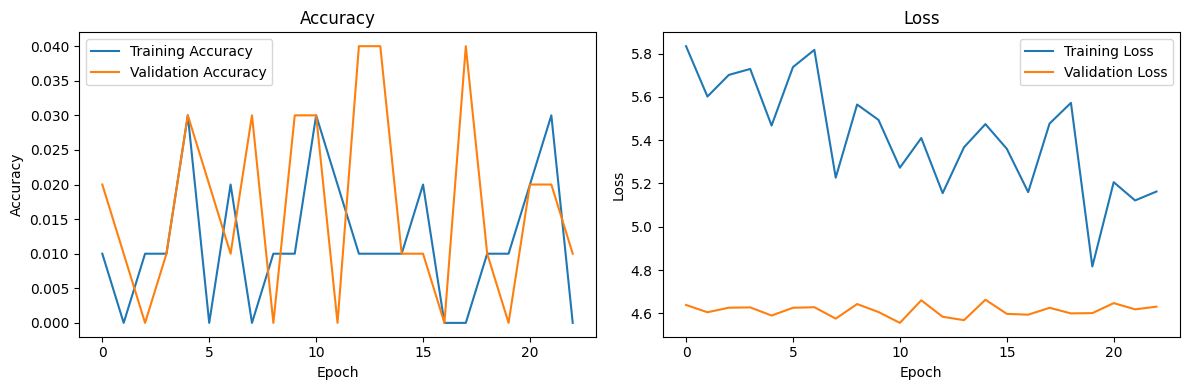

In [14]:
# Plot the training history
plot_training_history(history)

In [15]:
print(f"Model saved to {Config.MODEL_SAVE_PATH}")

Model saved to /kaggle/working/activity_recognition_model.keras


# End of Notebook🎀

This notebook demonstrated a full pipeline for human activity recognition using a memory-efficient CNN-LSTM model. Enjoy experimenting and improving the model further!

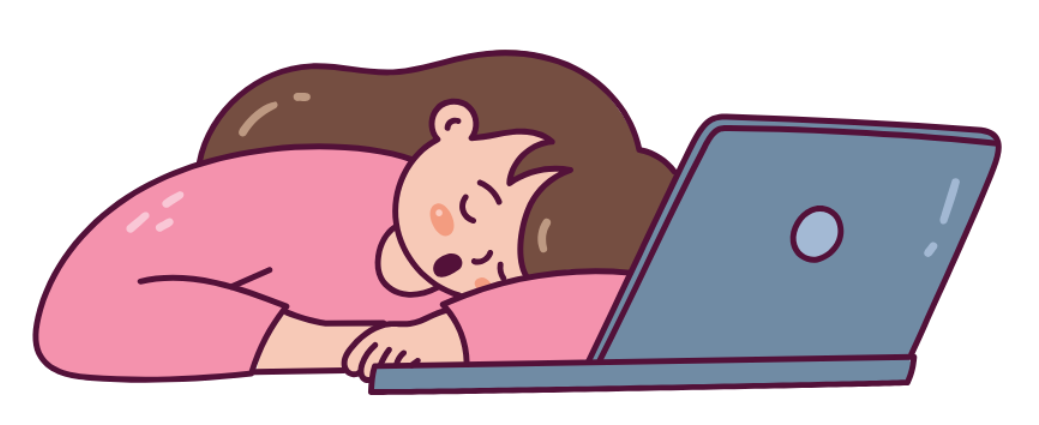

---------